In [2]:
# Importing necessary libraries
from support.funcs import *
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pptx import Presentation
from pptx.util import Inches
import json
import os
from io import BytesIO
from scipy.signal import savgol_filter

def make_list_ascending(lst):
    indexes = []
    for i in range(len(lst) - 1):
        if lst[i] >= lst[i + 1]:
            indexes.append(i + 1)
            lst[i + 1] += 0.001
    return lst


current_directory = os.getcwd()
# Read the JSON file containing the Session Directory
with open(current_directory+'\\SessionDirectory.json', 'r') as file:
    session_data = json.load(file)
    
# Get the directory path from the JSON data
pth = session_data["directory"]

# Getting the mocap data
df_mocap,starttime=read_df_csv(pth+'\\mocap.csv')

# converting to epoch time
epoch_time = starttime.timestamp() 
time=df_mocap['seconds'].to_numpy()
time=time+epoch_time
df_mocap.insert(1,'epoch_time',time)
df_mocap.drop(columns=['seconds'],inplace=True)

# applying savgol filter to mocap data 
df_mocap = pd.DataFrame(savgol_filter(df_mocap, int(len(df_mocap)/80) * 2 + 3, 3, axis=0),
                                columns=df_mocap.columns,
                                index=df_mocap.index)

# getting mpipe data
df_mpipe=pd.read_csv(pth+'\\mpipe_filtered.csv')

# Creating a presentation to save the graphs in
prs=Presentation()

# Create and save matplotlib graphs
graphs = []
RMSEs=[]

from scipy.interpolate import CubicSpline

df2=df_mocap.copy()

# Extract the x values from df_mpipe and df2
x = df_mpipe['epoch_time']
x_new = df2['epoch_time']
x=make_list_ascending(x)

# Loop through the columns of df2 (excluding epoch_time)
for column in df2.columns[1:]:
    # Extract the y values from df_mpipe for the current column
    y = df_mpipe[column]
    
    # Generate the interpolating function
    spline = CubicSpline(x,y)
    
    # Interpolate y values onto df2 for the current column
    interpolated_values = spline(x_new)
    
    # Add the interpolated values as a new column in df2
    df2['interpolated_' + column] = interpolated_values

df2.drop(df_mocap.columns,axis=1,inplace=True)

# Loop through the columns of the DataFrame
for column in df2.columns:
    # Remove the desired string from column names using str.replace()
    new_column_name = column.replace('interpolated_', '')

    # Rename the column with the updated name
    df2.rename(columns={column: new_column_name}, inplace=True)

# applying savgol filter to data 
df_filtered = pd.DataFrame(savgol_filter(df2, int(len(df2)/30) * 2 + 1, 3, axis=0),
                                 columns=df2.columns,
                                   index=df2.index)
df_filtered.insert(0, 'epoch_time', df_mocap['epoch_time'])

df_mpipe = df_filtered.copy()

In [3]:
def pvt(y,t):
    plt.plot(t,y)
    plt.xlabel('time(s)')   
    plt.ylabel('Angle(degrees)')
    plt.legend(['mediapipe','mocap'])

def save_graph_to_pptx(prs, graph, description, slide_width=6, slide_height=4.5):
    # Add a slide with a title and content layout
    slide_layout = prs.slide_layouts[1]
    slide = prs.slides.add_slide(slide_layout)
    
    # Add the graph to the slide
    left = Inches(0.5)
    top = Inches(1)
    width = Inches(slide_width)
    height = Inches(slide_height)
    slide.shapes.add_picture(graph, left, top, width, height)
    
    # Add the description as a text box
    txBox = slide.shapes.add_textbox(left, top + height + Inches(0.5), width, Inches(1))
    tf = txBox.text_frame
    p = tf.add_paragraph()
    p.text = description

In [4]:
# Calculating the elbow angle using mediapipe and mocap data
mpipeRightElbowAngle, mocapRightElbowAngle = [], []

# Calculate right elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeRightElbowAngle.append(angle3point([df_mpipe['RS_x'][i], df_mpipe['RS_y'][i], df_mpipe['RS_z'][i]],
                                            [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]],
                                            [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]]))

# Calculate right elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].to_numpy()-epoch_time)):
    mocapRightElbowAngle.append(angle3point([df_mocap['RS_x'][i], df_mocap['RS_y'][i], df_mocap['RS_z'][i]],
                                            [df_mocap['RE_x'][i], df_mocap['RE_y'][i], df_mocap['RE_z'][i]],
                                            [df_mocap['RW_x'][i], df_mocap['RW_y'][i], df_mocap['RW_z'][i]]))

mpipeLeftElbowAngle, mocapLeftElbowAngle = [], []

# Calculate left elbow angle using mediapipe data
for i in range(len(df_mpipe['epoch_time'].tolist())):
    mpipeLeftElbowAngle.append(angle3point([df_mpipe['LS_x'][i], df_mpipe['LS_y'][i], df_mpipe['LS_z'][i]],
                                           [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]],
                                           [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]]))

# Calculate left elbow angle using mocap data
for i in range(len(df_mocap['epoch_time'].tolist())):
    mocapLeftElbowAngle.append(angle3point([df_mocap['LS_x'][i], df_mocap['LS_y'][i], df_mocap['LS_z'][i]],
                                           [df_mocap['LE_x'][i], df_mocap['LE_y'][i], df_mocap['LE_z'][i]],
                                           [df_mocap['LW_x'][i], df_mocap['LW_y'][i], df_mocap['LW_z'][i]]))

RMSE of Right Elbow Angle:24.8862 
Max error :87.3439  at epoch_time :0.7200002670288086


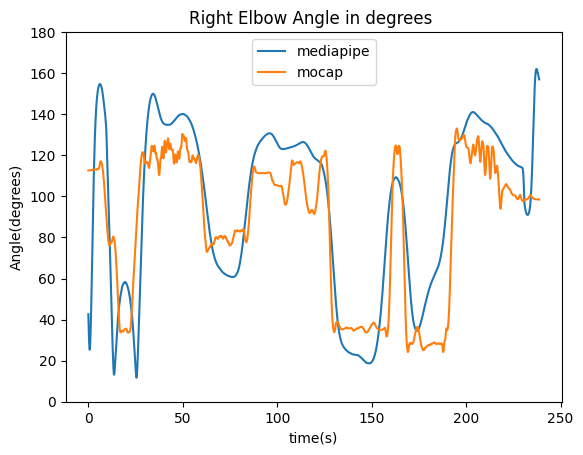

RMSE of Left Elbow Angle:13.1043 
Max error :58.8720  at epoch_time :233.84568309783936


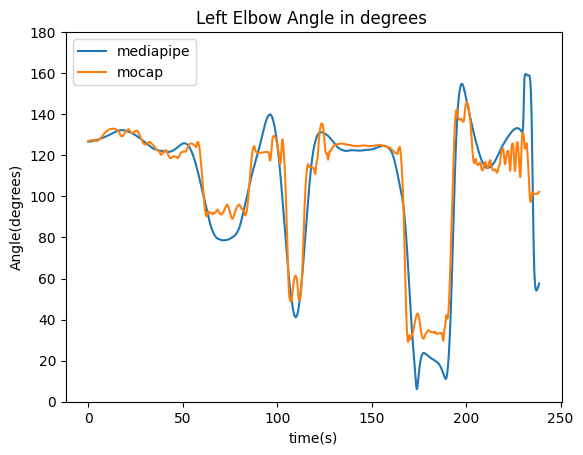

<Figure size 640x480 with 0 Axes>

In [5]:
# graph right elbow angle 
pvt(mpipeRightElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRightElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('Right Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapRightElbowAngle,mpipeRightElbowAngle)
RMSE_str='RMSE of Right Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)
plt.show()

# Clear the figure for the next graph
plt.clf()

#test graph left elbow angle 
pvt(mpipeLeftElbowAngle,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLeftElbowAngle,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('Left Elbow Angle in degrees ')
plt.ylim(0,180)
rmse,me,me_i=errors(mocapLeftElbowAngle,mpipeLeftElbowAngle)
RMSE_str='RMSE of Left Elbow Angle:'+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

In [6]:
def shoulder_frame(S,E,W):
    """"
        Find the vectors describing the local x,y,z axes of shoulder
    Parameters
    ----------
    S : shoulder point
    E : elbow point
    W : wrist point
        
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        S,E,W=np.array(S),np.array(E),np.array(W)
        upperarm=E-S
        lowerarm=W-E

        y=upperarm
        x=-np.cross(upperarm,lowerarm)
        z=np.cross(x,y)
        return np.array([x,y,z]).T
    except:
        print('error in shoulder_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def tr_frame(LS,RS,TR):
    """"
        Find the vectors describing the local x,y,z axes of trunk
    Parameters
    ----------
    LS : left shoulder point
    RS : right shoulder point
    TR : trunk/chest point
    
    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each column represents a vector.
    """
    try:
        LS,RS,TR=np.array(LS),np.array(RS),np.array(TR)

        v1=LS-RS
        v2=TR-RS

        basis=gram_schmidt([v1,v2])
        try:
            v1,v2=basis[0],basis[1]
        except:
            return np.nan
        v3=np.cross(v1,v2)

        return np.array([v1,v2,v3]).T

    except:
        print('error in tr_frame')
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

def gram_schmidt(vectors):
    """
        Orthonormalize a set of vectors using the Gram-Schmidt process.

    Parameters
    ----------
    vectors : list of numpy.ndarray
        A list of vectors to be orthonormalized.

    Returns
    -------
    numpy.ndarray
        An array of orthonormal vectors, where each row represents a vector.
    """
    basis = []
    for v in vectors:
        w = v - sum(np.dot(v,b)*b for b in basis)
        if (w > 1e-10).any():
            basis.append(w/np.linalg.norm(w))
    print(basis)
    return np.array(basis)


def rotation_matrix(frame1, frame2):
    """
    Calculate the rotation matrix that transforms frame1 to frame2.
    :param frame1: 3x3 numpy array representing the first coordinate frame
    :param frame2: 3x3 numpy array representing the second coordinate frame
    :return: 3x3 numpy array representing the rotation matrix
    """
    try:
        R = np.dot(frame2, np.linalg.inv(frame1))
        return R
    except:
        print('error in roation matrix calculation')
        print(frame1,frame2)
        return np .array([[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan],[np.nan,np.nan,np.nan]])

In [7]:
# callibrating shoulders and trunk

# setting the calibration to 2 seconds in the video
mpipe_cf = 200
mocap_cf = 200
RSC_mpipe=shoulder_frame([df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                         [df_mpipe['RE_x'][mpipe_cf],df_mpipe['RE_y'][mpipe_cf],df_mpipe['RE_z'][mpipe_cf]],
                         [df_mpipe['RW_x'][mpipe_cf],df_mpipe['RW_y'][mpipe_cf],df_mpipe['RW_z'][mpipe_cf]])

LSC_mpipe=shoulder_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                         [df_mpipe['LE_x'][mpipe_cf],df_mpipe['LE_y'][mpipe_cf],df_mpipe['LE_z'][mpipe_cf]],
                         [df_mpipe['LW_x'][mpipe_cf],df_mpipe['LW_y'][mpipe_cf],df_mpipe['LW_z'][mpipe_cf]])

TRC_mpipe=tr_frame([df_mpipe['LS_x'][mpipe_cf],df_mpipe['LS_y'][mpipe_cf],df_mpipe['LS_z'][mpipe_cf]],
                   [df_mpipe['RS_x'][mpipe_cf],df_mpipe['RS_y'][mpipe_cf],df_mpipe['RS_z'][mpipe_cf]],
                   [df_mpipe['TR_x'][mpipe_cf],df_mpipe['TR_y'][mpipe_cf],df_mpipe['TR_z'][mpipe_cf]])

RSC_mocap=shoulder_frame([df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                         [df_mocap['RE_x'][mocap_cf],df_mocap['RE_y'][mocap_cf],df_mocap['RE_z'][mocap_cf]],
                         [df_mocap['RW_x'][mocap_cf],df_mocap['RW_y'][mocap_cf],df_mocap['RW_z'][mocap_cf]])

LSC_mocap=shoulder_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                         [df_mocap['LE_x'][mocap_cf],df_mocap['LE_y'][mocap_cf],df_mocap['LE_z'][mocap_cf]],
                         [df_mocap['LW_x'][mocap_cf],df_mocap['LW_y'][mocap_cf],df_mocap['LW_z'][mocap_cf]])

TRC_mocap=tr_frame([df_mocap['LS_x'][mocap_cf],df_mocap['LS_y'][mocap_cf],df_mocap['LS_z'][mocap_cf]],
                   [df_mocap['RS_x'][mocap_cf],df_mocap['RS_y'][mocap_cf],df_mocap['RS_z'][mocap_cf]],
                   [df_mocap['TR_x'][mocap_cf],df_mocap['TR_y'][mocap_cf],df_mocap['TR_z'][mocap_cf]])

In [8]:
df_mpipe

,epoch_time,LE_x,LE_y,LE_z,LS_x,LS_y,LS_z,LW_x,LW_y,LW_z,...,RE_z,RS_x,RS_y,RS_z,RW_x,RW_y,RW_z,TR_x,TR_y,TR_z
0,1.688796e+09,0.414474,0.072508,-0.286701,0.362721,0.272696,-0.383885,0.388451,-0.014111,0.084484,...,-0.406788,0.022035,0.290970,0.141315,0.090838,0.207498,-0.303266,0.240998,0.138418,-0.737556
1,1.688796e+09,0.414483,0.072463,-0.286686,0.362746,0.272689,-0.383886,0.388472,-0.014123,0.084360,...,-0.406158,0.022097,0.290842,0.139228,0.090554,0.206443,-0.301727,0.240849,0.138582,-0.736075
2,1.688796e+09,0.414492,0.072418,-0.286670,0.362771,0.272683,-0.383886,0.388493,-0.014134,0.084237,...,-0.405530,0.022158,0.290714,0.137145,0.090270,0.205391,-0.300192,0.240699,0.138747,-0.734597
3,1.688796e+09,0.414502,0.072373,-0.286655,0.362796,0.272676,-0.383887,0.388513,-0.014146,0.084114,...,-0.404902,0.022220,0.290586,0.135065,0.089987,0.204341,-0.298659,0.240550,0.138911,-0.733121
4,1.688796e+09,0.414511,0.072329,-0.286640,0.362821,0.272669,-0.383887,0.388534,-0.014158,0.083991,...,-0.404276,0.022281,0.290458,0.132989,0.089705,0.203293,-0.297129,0.240401,0.139074,-0.731648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23868,1.688796e+09,1.240839,-0.074943,-4.705382,0.953981,0.602371,-3.066888,0.369312,-0.465258,-3.994811,...,-0.560237,0.282866,0.366215,-1.499636,-0.137783,0.288409,0.801016,0.529961,0.311387,-2.068029
23869,1.688796e+09,1.244544,-0.075557,-4.725238,0.956653,0.603903,-3.079164,0.369231,-0.467279,-4.013073,...,-0.561352,0.284010,0.366696,-1.504708,-0.138441,0.289836,0.804603,0.531492,0.311964,-2.076023
23870,1.688796e+09,1.248257,-0.076171,-4.745142,0.959331,0.605438,-3.091471,0.369148,-0.469305,-4.031379,...,-0.562470,0.285157,0.367178,-1.509792,-0.139100,0.291266,0.808199,0.533026,0.312544,-2.084036
23871,1.688796e+09,1.251979,-0.076787,-4.765094,0.962016,0.606977,-3.103807,0.369066,-0.471336,-4.049730,...,-0.563591,0.286307,0.367662,-1.514888,-0.139760,0.292700,0.811803,0.534564,0.313124,-2.092068


In [13]:
# calculating the euler angles

# mpipe values
mpipeRSFE,mpipeRSAA,mpipeRSIE=[],[],[]
mpipeLSFE,mpipeLSAA,mpipeLSIE=[],[],[]
mpipeTRFB,mpipeTRLR,mpipeTRRO=[],[],[]

# Elbow Angle threshold for calculating internal/external rotation angle
eath=160

for i in range(len(df_mpipe['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mpipeRSF=shoulder_frame([df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],
                            [df_mpipe['RE_x'][i],df_mpipe['RE_y'][i],df_mpipe['RE_z'][i]],
                            [df_mpipe['RW_x'][i],df_mpipe['RW_y'][i],df_mpipe['RW_z'][i]])
   
    mpipeLSF=shoulder_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                            [df_mpipe['LE_x'][i],df_mpipe['LE_y'][i],df_mpipe['LE_z'][i]],
                            [df_mpipe['LW_x'][i],df_mpipe['LW_y'][i],df_mpipe['LW_z'][i]])
   
    mpipeTRF=tr_frame([df_mpipe['LS_x'][i],df_mpipe['LS_y'][i],df_mpipe['LS_z'][i]],
                      [df_mpipe['RS_x'][i],df_mpipe['RS_y'][i],df_mpipe['RS_z'][i]],  
                      [df_mpipe['TR_x'][i],df_mpipe['TR_y'][i],df_mpipe['TR_z'][i]])
    
    print(mpipeTRF)
    break
    
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mpipeTR_rotmat=rotation_matrix(TRC_mpipe,mpipeTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mpipe_rotated_RS_Cframe=mpipeTR_rotmat@RSC_mpipe
    mpipe_rotated_LS_Cframe=mpipeTR_rotmat@LSC_mpipe


    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mpipeRS_rotmat=rotation_matrix(mpipe_rotated_RS_Cframe,mpipeRSF)
    mpipeLS_rotmat=rotation_matrix(mpipe_rotated_LS_Cframe,mpipeLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mpipeRS_rotmat)
    LSeuler=rotation_angles(mpipeLS_rotmat)
    TReuler=rotation_angles(mpipeTR_rotmat)

    # appending to angle lists
    mpipeRSFE.append(RSeuler[0])
    mpipeRSAA.append(RSeuler[1])
    if mpipeRightElbowAngle[i] < eath:
        mpipeRSIE.append(RSeuler[2])
    else:
        mpipeRSIE.append(np.nan)

    mpipeLSFE.append(LSeuler[0])
    mpipeLSAA.append(LSeuler[1])
    if mpipeLeftElbowAngle[i] < eath:
        mpipeLSIE.append(LSeuler[2])
    else:
        mpipeLSIE.append(np.nan)

    mpipeTRFB.append(TReuler[0])
    mpipeTRLR.append(TReuler[1])
    mpipeTRRO.append(TReuler[2])

# mocap values
mocapRSFE,mocapRSAA,mocapRSIE=[],[],[]
mocapLSFE,mocapLSAA,mocapLSIE=[],[],[]
mocapTRFB,mocapTRLR,mocapTRRO=[],[],[]

for i in range(len(df_mocap['epoch_time'].tolist())):

    # finding the ith shoulder/trunk frames
    mocapRSF=shoulder_frame([df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],
                            [df_mocap['RE_x'][i],df_mocap['RE_y'][i],df_mocap['RE_z'][i]],
                            [df_mocap['RW_x'][i],df_mocap['RW_y'][i],df_mocap['RW_z'][i]])
   
    mocapLSF=shoulder_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                            [df_mocap['LE_x'][i],df_mocap['LE_y'][i],df_mocap['LE_z'][i]],
                            [df_mocap['LW_x'][i],df_mocap['LW_y'][i],df_mocap['LW_z'][i]])
   
    mocapTRF=tr_frame([df_mocap['LS_x'][i],df_mocap['LS_y'][i],df_mocap['LS_z'][i]],
                      [df_mocap['RS_x'][i],df_mocap['RS_y'][i],df_mocap['RS_z'][i]],  
                      [df_mocap['TR_x'][i],df_mocap['TR_y'][i],df_mocap['TR_z'][i]])
   
    # finding the rotation matrix from callibration trunk frame to ith trunk frame
    mocapTR_rotmat=rotation_matrix(TRC_mocap,mocapTRF)

    # rotating shoulder callibration frame by same the rotation matrix
    mocap_rotated_RS_Cframe=mocapTR_rotmat@RSC_mocap
    mocap_rotated_LS_Cframe=mocapTR_rotmat@LSC_mocap

    # now finding rotation matrix from rotated shoulder callibration frame to ith shoulder frame
    mocapRS_rotmat=rotation_matrix(mocap_rotated_RS_Cframe,mocapRSF)
    mocapLS_rotmat=rotation_matrix(mocap_rotated_LS_Cframe,mocapLSF)

    # finding euler angles from rotation matrices
    RSeuler=rotation_angles(mocapRS_rotmat)
    LSeuler=rotation_angles(mocapLS_rotmat)
    TReuler=rotation_angles(mocapTR_rotmat)

    # appending to angle lists
    mocapRSFE.append(RSeuler[0])
    mocapRSAA.append(RSeuler[1])
    if mocapRightElbowAngle[i] < eath:
        mocapRSIE.append(RSeuler[2])
    else:
        mocapRSIE.append(np.nan)

    mocapLSFE.append(LSeuler[0])
    mocapLSAA.append(LSeuler[1])
    if mocapLeftElbowAngle[i] < eath:
        mocapLSIE.append(LSeuler[2])
    else:
        mocapLSIE.append(np.nan)
    
    mocapTRFB.append(TReuler[0])
    mocapTRLR.append(TReuler[1])
    mocapTRRO.append(TReuler[2])

[[-0.03786826 -0.06280657 -0.03939419]
 [ 0.06563386 -0.18808589 -0.01961368]
 [-0.01818348 -0.54810336  0.01124472]]
nan


ValueError: x and y must have same first dimension, but have shapes (23873,) and (0,)

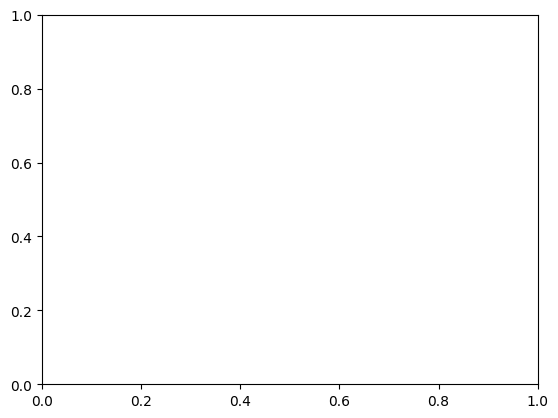

In [10]:
# plotting the trunk angles
pvt(mpipeTRFB,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapTRFB,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('trunk forward/backward')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRFB,mpipeTRFB)
RMSE_str='RMSE of trunk forward/backward: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)
# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()


pvt(mpipeTRLR,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapTRLR,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('trunk left/right')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRLR,mpipeTRLR)
RMSE_str='RMSE of trunk left/right: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeTRRO,df_mpipe['epoch_time'].tolist())
pvt(mocapTRRO,df_mocap['epoch_time'].tolist())
plt.title('trunk rotation')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapTRRO,mpipeTRRO)
RMSE_str='RMSE of trunk rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

RMSE of right shoulder flexion/extension: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


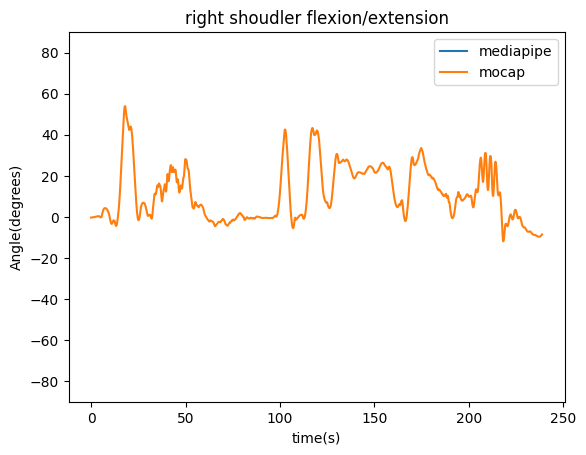

RMSE of right shoulder abduction/adduction: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


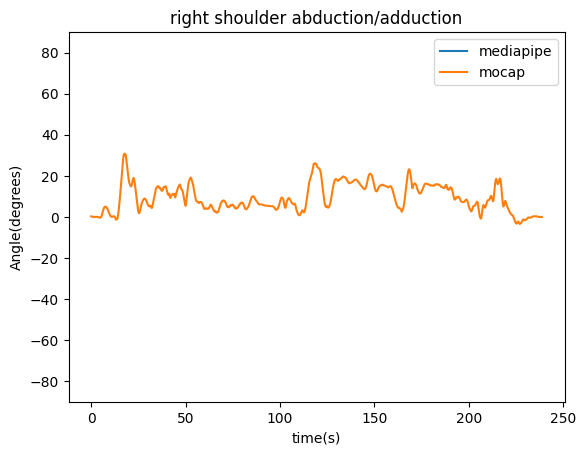

RMSE of right shoulder internal/external rotation: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


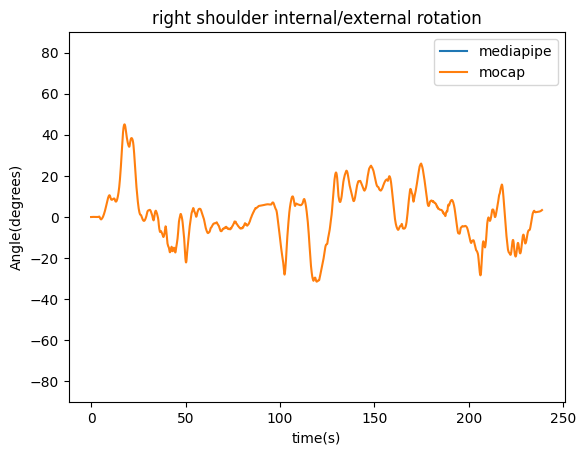

RMSE of left shoulder flexion/extension: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


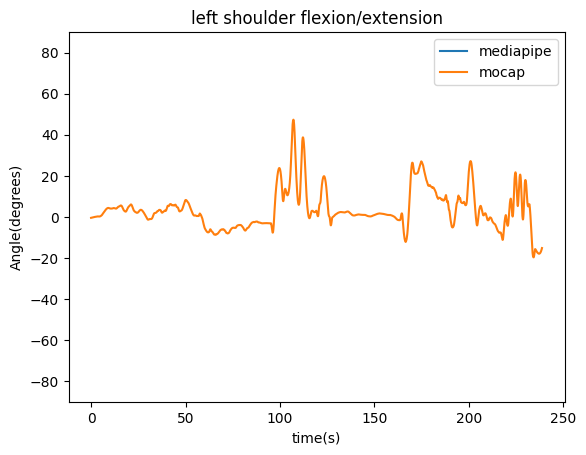

RMSE of left shoulder abduction/adduction: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


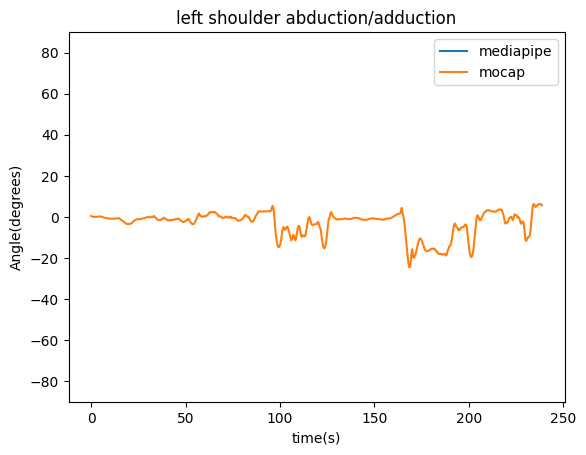

RMSE of left shoulder internal/external rotation: nan 
Max error :nan  at epoch_time :2.384185791015625e-07


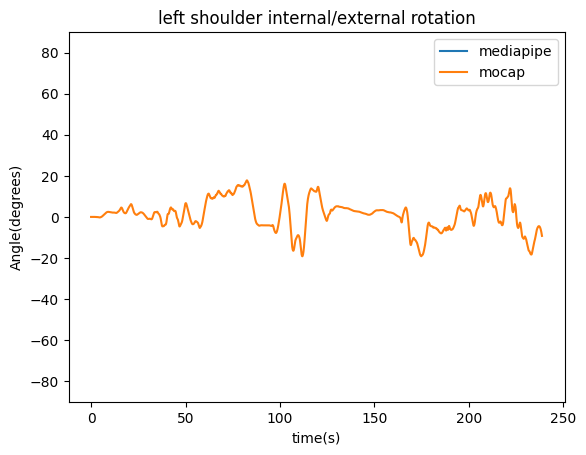

<Figure size 640x480 with 0 Axes>

In [ ]:
# Plotting the shoulder angles
pvt(mpipeRSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRSFE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.legend(['mediapipe','mocap'])
plt.title('right shoudler flexion/extension')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapRSFE,mpipeRSFE)
RMSE_str='RMSE of right shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeRSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapRSAA,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('right shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapRSAA,mpipeRSAA)
RMSE_str='RMSE of right shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

try:
    pvt(mpipeRSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
    pvt(mocapRSIE,df_mocap['epoch_time'].to_numpy()-epoch_time)
    plt.title('right shoulder internal/external rotation')
    plt.ylim(-90,90)
    rmse,me,me_i = errors(mocapRSIE,mpipeRSIE)
    RMSE_str='RMSE of right shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
    print(RMSE_str)

    # Save the graph to an in-memory buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Save the buffer to a list
    graphs.append(buffer)
    RMSEs.append(RMSE_str)

    plt.show()

    # Clear the figure for the next graph
    plt.clf()
except:
    pass
pvt(mpipeLSFE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLSFE,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('left shoulder flexion/extension')
plt.ylim(-90,90)
rmse, me , me_i =errors(mocapLSFE,mpipeLSFE)
RMSE_str='RMSE of left shoulder flexion/extension: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

pvt(mpipeLSAA,df_mpipe['epoch_time'].to_numpy()-epoch_time)
pvt(mocapLSAA,df_mocap['epoch_time'].to_numpy()-epoch_time)
plt.title('left shoulder abduction/adduction')
plt.ylim(-90,90)
rmse,me,me_i=errors(mocapLSAA,mpipeLSAA)
RMSE_str='RMSE of left shoulder abduction/adduction: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
print(RMSE_str)

# Save the graph to an in-memory buffer
buffer = BytesIO()
plt.savefig(buffer, format='png')
buffer.seek(0)

# Save the buffer to a list
graphs.append(buffer)
RMSEs.append(RMSE_str)

plt.show()

# Clear the figure for the next graph
plt.clf()

try:
    pvt(mpipeLSIE,df_mpipe['epoch_time'].to_numpy()-epoch_time)
    pvt(mocapLSIE,df_mocap['epoch_time'].to_numpy()-epoch_time)
    plt.title('left shoulder internal/external rotation')
    plt.ylim(-90,90)
    rmse, me , me_i = errors(mocapLSIE,mpipeLSIE)
    RMSE_str='RMSE of left shoulder internal/external rotation: '+str(f"{rmse:.4f} \nMax error :{me:.4f}  at epoch_time :{(df_mpipe['epoch_time'].to_numpy()-epoch_time)[me_i]}")
    print(RMSE_str)

    # Save the graph to an in-memory buffer
    buffer = BytesIO()
    plt.savefig(buffer, format='png')
    buffer.seek(0)

    # Save the buffer to a list
    graphs.append(buffer)
    RMSEs.append(RMSE_str)

    plt.show()

    # Clear the figure for the next graph
    plt.clf()
except:
    pass

In [ ]:
# delete the previous graphs pptx if it exists
try:
    os.remove(pth+'\\graphs_i.pptx')
except:
    pass
# Save the graphs to the PowerPoint presentation
for graph,error in zip(graphs,RMSEs):
    save_graph_to_pptx(prs, graph, error)

# Save the presentation
prs.save(pth+'\\graphs_i.pptx')

In [ ]:
# # Calculate Wrist dorsifexion / volar flexion
# mpipeRightWristAngle, mpipeLeftWristAngle = [], []

# # Calculate right elbow angle using mediapipe data
# for i in range(len(df_mpipe['epoch_time'].tolist())):
#     mpipeRightWristAngle.append(angle3point([df_mpipe['RI_x'][i], df_mpipe['RI_y'][i], df_mpipe['RI_z'][i]],
#                                             [df_mpipe['RW_x'][i], df_mpipe['RW_y'][i], df_mpipe['RW_z'][i]],
#                                             [df_mpipe['RE_x'][i], df_mpipe['RE_y'][i], df_mpipe['RE_z'][i]]))
    
#     mpipeLeftWristAngle.append(angle3point([df_mpipe['LI_x'][i], df_mpipe['LI_y'][i], df_mpipe['LI_z'][i]],
#                                            [df_mpipe['LW_x'][i], df_mpipe['LW_y'][i], df_mpipe['LW_z'][i]],
#                                            [df_mpipe['LE_x'][i], df_mpipe['LE_y'][i], df_mpipe['LE_z'][i]]))



In [ ]:
# # Plotting the Wrist dorsifexion / volar flexion angles
# pvt(mpipeRightWristAngle,df_mpipe['epoch_time'])
# plt.title('right Wrist dorsifexion / volar flexion')
# plt.ylim(0,180)
# plt.show()


# pvt(mpipeLeftWristAngle,df_mpipe['epoch_time'])
# plt.title('Left Wrist dorsifexion / volar flexion')
# plt.ylim(0,180)
# plt.show

In [ ]:
# Calculate Pronation/supination

# setting calibration as 90 degrees pronation



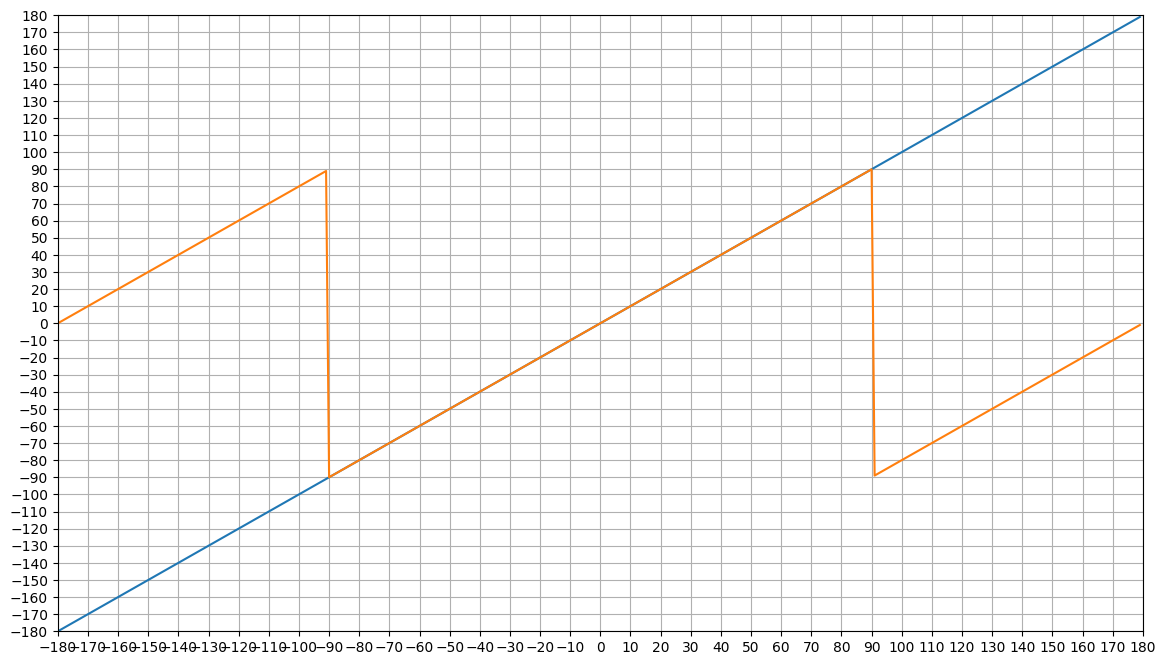

In [ ]:
from matplotlib.ticker import MultipleLocator

myval = []
nval,cval=[],[]
start,stop= -180,180
for i in range(start,stop):
    myval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))

    theta=i
    c=np.tan(np.deg2rad(theta))
    theta_check = False
    if theta < 0: 
        theta_check = True 
    
    if not theta_check:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(180+np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
    else:

        if np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))) < 0:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i)))))
        else:
            cval.append(np.rad2deg(np.arctan(np.sin(np.deg2rad(i))/np.cos(np.deg2rad(i))))-180)

# Create a figure and an axis
fig, ax = plt.subplots(figsize=(14, 8))

# Plot the data
ax.plot(range(start,stop),cval)
ax.plot(range(start,stop),myval)

# Set the major ticks on the y-axis to be at multiples of 10
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.xaxis.set_major_locator(MultipleLocator(10))

# Show the grid lines
ax.grid(True)
plt.ylim(-180,180)
plt.xlim(-180,180)
plt.show()